In [218]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
from geopy.distance import geodesic

# Data preparation

In [243]:
location = 'Sahara'

if location == 'London':

    mat = scipy.io.loadmat('ch_cell.mat')
    meta_data = scipy.io.loadmat('resp_cell.mat')

    ch = mat['ch_cell'] #### num_tx by num_rx
    dist = mat['dist']

    cir_profile = meta_data['resp_cell']


elif location == 'Sahara':
    meta_data = scipy.io.loadmat('sahara_cell.mat')
    cir_profile = meta_data['sahara_cell']['cir'][0][0]
    dist = meta_data['sahara_cell']['dist'][0][0]

    Y = meta_data['sahara_cell'][0][0]['tx'].T # coordination of agents (lat, lon)
    RX = meta_data['sahara_cell'][0][0]['rx'].T
    # Y[:, 0] *= 1e3 # Coordination scaled by 1000 



In [244]:
ray_len = []
delay_set = []
time_range = []

for chs in cir_profile:
    for ch in chs:
        ray_len.append(len(ch[0,:]))
        delay_set.extend(ch[0, :])
        time_range.append(max(ch[0, :]))

max_reflection = max(ray_len)
mag = - math.floor(math.log(np.mean(delay_set), 10))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


Text(0.5, 1.0, 'Distribution of delaying time')

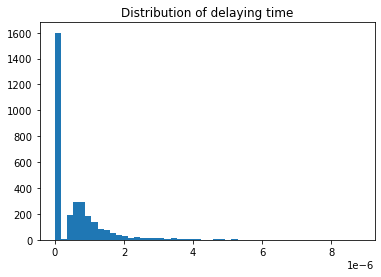

In [245]:
_ = plt.hist(delay_set, bins=50)
plt.title('Distribution of delaying time')

Text(0.5, 0, '#-of-raytraces')

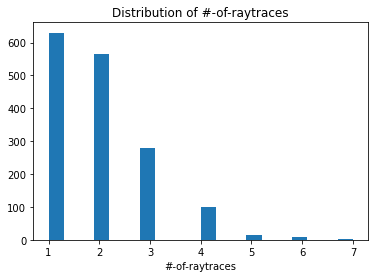

In [246]:
_ = plt.hist(ray_len, bins=20)
plt.title('Distribution of #-of-raytraces')
plt.xlabel('#-of-raytraces')

In [247]:
def z2polar(z):
    '''
    cartisan to polar coordinates
    '''
    return ( abs(z), np.angle(z) )

In [170]:
# prepare X

T, S = cir_profile.shape
x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile[j, i]
        c_tmp[0, :] = c_tmp[0, :] * 10 ** mag # normalize the delay seconds
        
        m, n = c_tmp.shape
        if m == 2:
            c_tmp[1, :] = abs(c_tmp[1, :])
            
        cir_shaped = np.pad(c_tmp, \
            ((0,2-m), (0, max_reflection-n)), \
                constant_values=0).flatten() # padding 0 to shape of (2, max_len)
        cir_t.append(np.array(cir_shaped, dtype='float'))

    x_pre.append(np.array(cir_t).flatten())

X = np.array(x_pre)  

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<StemContainer object of 3 artists>

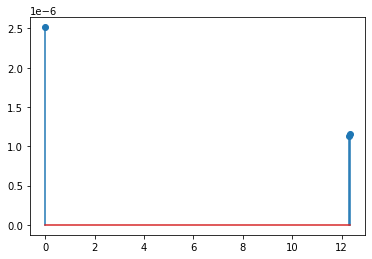

In [171]:
t = cir_profile[10,0]
plt.stem(t[0,:], t[1, :])

In [ ]:
X = cir_profile
mode = 'cov'
T, S = X.shape
x_pre = []
max_len = max_reflection * (max_reflection + 1) // 2

for j in range(T):
    cir_t = [] # channel impulse response for a tx to all rx
    for i in range(S):
        c_tmp = X[j, i] # cir response for t_j and r_i
        c_tmp[0, :] = c_tmp[0, :] * 10 ** mag # normalize the delay seconds            
        m, n = c_tmp.shape # m - 2, n - num of traces
        if m == 2:
            if mode == 'cov':


                if n == 1:
                    cir_cov = np.cov(c_tmp.T)

                    cov_real = cir_cov.real
                    cov_imag = cir_cov.imag 
                    real_flatten = np.array([cov_real])
                    imag_flatten = np.array([cov_imag])
                    pad_zero = np.zeros(max_len - n)

                    tmp = np.concatenate([real_flatten, pad_zero, imag_flatten, pad_zero])
                    cir_t.append(tmp)

                else:
                    cir_cov = np.cov(c_tmp.T)
                    cir_cov /= np.trace(cir_cov)
                    cov_real = cir_cov.real
                    cov_imag = cir_cov.imag               

                    real_flatten = cov_real[np.triu_indices(n)]
                    imag_flatten = cov_imag[np.triu_indices(n)]

                    real_pad = np.pad(real_flatten, (0, max_len - len(real_flatten)), constant_values=0)
                    imag_pad = np.pad(imag_flatten, (0, max_len - len(imag_flatten)), constant_values=0)

                    print(max(real_pad), max(imag_pad))

                    cir_t.append(np.concatenate([real_pad, imag_pad]))
            elif mode == 'abs':
                c_tmp[1, :] = abs(c_tmp[1, :])
                cir_shaped = np.pad(c_tmp, \
                    ((0,2-m), (0, max_reflection-n)), \
                        constant_values=0).flatten() # padding 0 to shape of (2, max_len)
                cir_t.append(np.array(cir_shaped, dtype='float'))

        else:
            if mode == 'cov':
                cir_t.append(np.zeros(max_len * 2))

            elif mode == 'abs':
                cir_shaped = np.pad(c_tmp, \
                    ((0,2-m), (0, max_reflection-n)), \
                        constant_values=0).flatten() # padding 0 to shape of (2, max_len)
                cir_t.append(np.array(cir_shaped, dtype='float'))

    x_pre.append(np.concatenate(np.array(cir_t), axis=0))


# Learning

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [258]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = meta_data['sahara_cell'][0][0]['tx'].T # lat, lon
# Y[0, :], Y[1, :] = Y[1, :], Y[0, :] # change the order of lat and lon increases the accuracy (lon, lat)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, train_size=.75)
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=1000, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# xgb_reg = xgb.XGBRegressor()
model = MultiOutputRegressor(xgb_reg)

_ = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

Text(0, 0.5, 'Longitude')

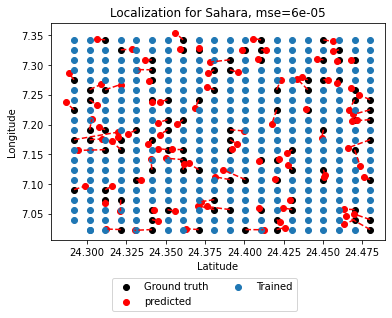

In [257]:
fig, ax = plt.subplots()

ax.scatter(y_test[:, 0], y_test[:, 1], color='k', label='Ground truth')
ax.plot([y_test.T[0, :], y_pred.T[0, :]], [y_test.T[1, :], y_pred.T[1, :]], '--', c='r')
ax.scatter(y_pred[:, 0], y_pred[:,1], color='r', label='predicted')
ax.scatter(y_train[:, 0], y_train[:, 1], label='Trained')
ax.set_title(f'Localization for Sahara, mse={round(mse,5)}')
# ax.legend(loc='best')
ax.legend(ncol=2, bbox_to_anchor=(.75, -.15))
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')


In [267]:
geodesic(Y[1, :], Y[21, :]), geodesic(Y[1, :], Y[2, :])

(Distance(1.7038193362302483), Distance(1.097716333332199))

In [266]:
Y[0], Y[1], Y[2]

(array([24.30161053,  7.0237    ]),
 array([24.30161053,  7.0237    ]),
 array([24.31152105,  7.0237    ]))

Text(0, 0.5, 'Latitude')

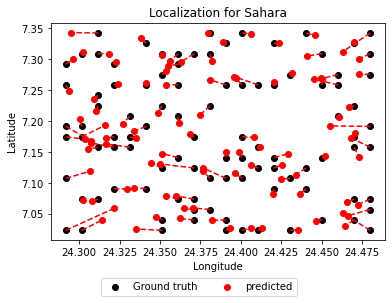

In [208]:
fig, ax = plt.subplots()

ax.scatter(y_test[:, 0], y_test[:, 1], color='k', label='Ground truth')
ax.plot([y_test.T[0, :], y_pred.T[0, :]], [y_test.T[1, :], y_pred.T[1, :]], '--', c='r')
ax.scatter(y_pred[:, 0], y_pred[:,1], color='r', label='predicted')
ax.set_title('Localization for Sahara')
# ax.legend(loc='best')
ax.legend(ncol=2, bbox_to_anchor=(.75, -.15))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [249]:
dist = [geodesic(i, j).km for i, j in zip(y_test, y_pred)]


Text(0.5, 1.0, 'Distribution of estimation error')

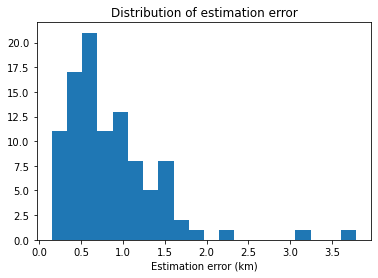

In [251]:
plt.hist(dist, bins=20)
plt.xlabel('Estimation error (km)')
plt.title('Distribution of estimation error')

(array([ 4.,  4.,  9., 13., 12., 12.,  4., 10.,  6.,  6.,  7.,  0.,  5.,
         1.,  2.,  1.,  2.,  1.,  0.,  1.]),
 array([0.07764464, 0.21095598, 0.34426731, 0.47757864, 0.61088997,
        0.7442013 , 0.87751264, 1.01082397, 1.1441353 , 1.27744663,
        1.41075796, 1.54406929, 1.67738063, 1.81069196, 1.94400329,
        2.07731462, 2.21062595, 2.34393729, 2.47724862, 2.61055995,
        2.74387128]),
 <a list of 20 Patch objects>)

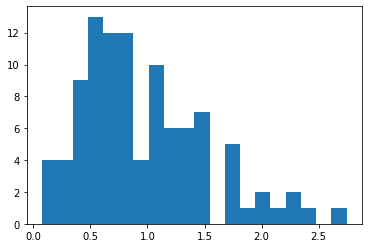

In [163]:
plt.hist(dist, bins=20)

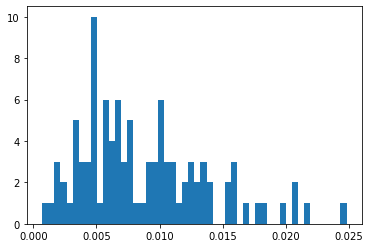

In [83]:
_ = plt.hist(diff.diagonal(), bins=50)

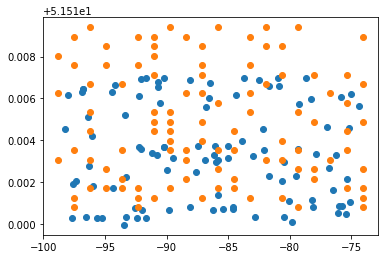

In [419]:
plt.scatter(y_pred[:, 0], y_pred[:,1])
plt.scatter(y_test[:, 0], y_test[:, 1])

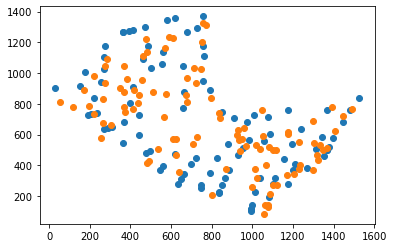

In [27]:
plt.scatter(y_test[:, 0], y_test[:, 2])
plt.scatter(y_pred[:, 0], y_pred[:, 2])

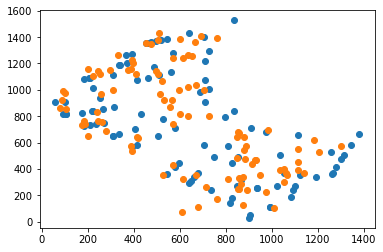

In [28]:
plt.scatter(y_test[:, 3], y_test[:, 1])
plt.scatter(y_pred[:, 3], y_pred[:, 1])

## Extreme learning machine

In [342]:
import numpy as np

In [344]:
np.__version__

'1.21.6'

In [343]:
import elm

ContextualVersionConflict: (numpy 1.21.6 (c:\users\lenovo\appdata\roaming\python\python37\site-packages), Requirement.parse('numpy==1.15.4'), {'elm'})

In [320]:
!pip uninstall numpy


^C


In [339]:
!pip install --upgrade numpy==1.15.4

You should consider upgrading via the 'D:\Users\lenovo\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.
